<a href="https://colab.research.google.com/github/ashma01/GANs/blob/master/WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import zipfile
import shutil
import os
import pandas as pd
import random
from torchvision.utils import save_image
from IPython.display import Image
from torchvision.utils import save_image

# Set random seed for reproducibility
manualSeed = 999
# manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


Random Seed:  999


In [ ]:
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip 

--2022-04-21 23:06:03--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.113.88
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.113.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  74.3MB/s    in 17s     

2022-04-21 23:06:20 (80.1 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]



In [ ]:
with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")

In [ ]:
root = 'data_faces/img_align_celeba'
img_list = os.listdir(root)
print(len(img_list))

202599


In [ ]:
# Root directory for dataset
dataroot = "/content/data_faces"

# Batch size during training
batch_size = 64
image_size = 64
nc = 3
nz = 128
ngf = 64
ndf = 64
num_epochs = 10
beta1 = 0.0
learning_rate = 5e-5

#critin iteration
critic_iter = 5

#GP penalty 
# gp_penalty = 10

#Weight clip
clamp_num = 0.01


In [ ]:
#Load celeba dataset data set

dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))


In [ ]:
from torch.utils.data import DataLoader


dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=4)



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
def show_images(images, nmax=64):
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach().cpu()[:nmax]), nrow=8).permute(1, 2, 0))
  
def show_batch(dl, nmax=64):
  for images, _ in dl:
    show_images(images, nmax)
    break

In [ ]:
# show_batch(dataloader)

In [ ]:
# custom weights initialization called on Generator and Discriminator
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [ ]:
#Discriminator
class Discriminator(nn.Module):
  def __init__(self):
          super(Discriminator, self).__init__()
          self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Flatten(),
            # nn.Sigmoid()
        )

  def forward(self, input):
      return self.main(input)     



critic = Discriminator().to(device);
critic.apply(weights_init)



Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Flatten(start_dim=1, end_dim=-1)
  )
)

In [ ]:
#Generator network 

class Generator(nn.Module):
  def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
  def forward(self, input):
          return self.main(input)

    

Generator_model = Generator().to(device);  
Generator_model.apply(weights_init) 

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [ ]:
print(Generator_model)
print(critic)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


torch.Size([64, 3, 64, 64])


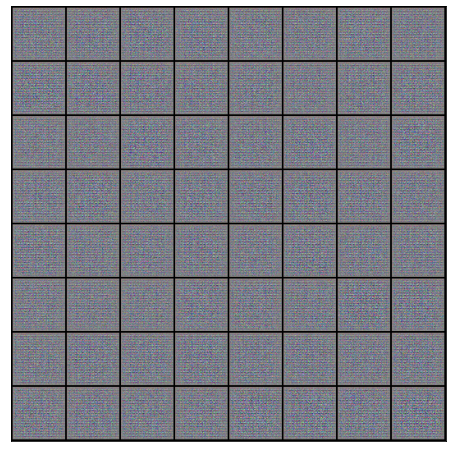

In [ ]:
randon_noise = torch.randn(batch_size, nz, 1, 1).to(device) # random latent tensors
fake_images = Generator_model(randon_noise)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
#For discriminator training using binary cross entropy loss
# criterion = nn.BCELoss()
d_optimizer = torch.optim.RMSprop(critic.parameters(), lr=learning_rate)
g_optimizer = torch.optim.RMSprop(Generator_model.parameters(), lr=learning_rate)

In [ ]:

def gradient_penalty(critic, real, fake, device = device):
    BATCH_SIZE = real.size()[0]
    alpha = torch.rand(BATCH_SIZE, nc, image_size, image_size).to(device)

    # batch_size = real.size()[0]

    #     # Calculate interpolation
    # alpha = torch.rand(batch_size, nc, 1, 1).to(device)
    # alpha = alpha.expand_as(real)
    # alpha = torch.rand(batch_size, nc, 1, 1).to(device)
    # alpha = alpha.expand(cuda_image(real))
    # alpha = alpha.to(device)
  

    # alpha = torch.rand(batch_size, 1).to(real)
    # alpha = alpha.expand(batch_size, real.nelement()//batch_size).contiguous()
    # alpha = alpha.view(batch_size, nc, image_size, image_size)

    interpolated_images = real * alpha + (fake * (1 - alpha))

    interpolated_images = interpolated_images.to(device)
    interpolated_images = torch.autograd.Variable(interpolated_images, requires_grad=True)
    
    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    gradient = torch.autograd.grad(
              outputs=mixed_scores,
              inputs=interpolated_images,
              grad_outputs=torch.ones(mixed_scores.size()).to(device),
              create_graph=True,
              retain_graph=True,
              only_inputs=True
              )[0]
    
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [ ]:
# utility function
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

In [ ]:
#Train discriminator
def train_discriminator(images):
    # real_labels = torch.ones(images.size(0), 1, device=device)
   
    # for p in critic.parameters(): # update D
    #             p.requires_grad = True  

    # for p in Generator_model.parameters(): # freeze G
    #             p.requires_grad = False      
    # calculate loss on real image
    real_image_outputs = critic(images)
    d_real_image_loss = -torch.mean(real_image_outputs) #criterion(outputs, real_labels)
    real_score = real_image_outputs

    # generate fake images and calculate loss on fake image
    z = torch.randn(batch_size, nz, 1, 1, device=device)
    fake_images = Generator_model(z)
    # fake_labels = torch.zeros(fake_images.size(0), 1, device=device)
    fake_image_outputs = critic(fake_images)
    d_fake_image_loss = torch.mean(fake_image_outputs) #criterion(outputs, fake_labels)
    fake_score = fake_image_outputs

    #loss addition
    # gp = gradient_penalty(critic, real_image_outputs, fake_image_outputs, device=device)
    crit_loss = d_real_image_loss + d_fake_image_loss
    # set zero grad
    reset_grad()
    # backword
    crit_loss.backward()
    # forword
    d_optimizer.step()
    
    return crit_loss, real_score, fake_score


In [ ]:
#Generator training

def train_generator():
    # for p in critic.parameters(): # update D
    #             p.requires_grad = False  

    # for p in Generator_model.parameters(): # freeze G
    #             p.requires_grad = True 
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, nz, 1,1, device=device)
    fake_images = Generator_model(z)
    # labels = torch.ones(batch_size, 1, device=device)
    # Passing fake images and calculating loss on real label
    dis_output = critic(fake_images)
    g_loss = -torch.mean(dis_output) #criterion(Discriminator_model(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

In [ ]:
import os
# Saving data to visiualization
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

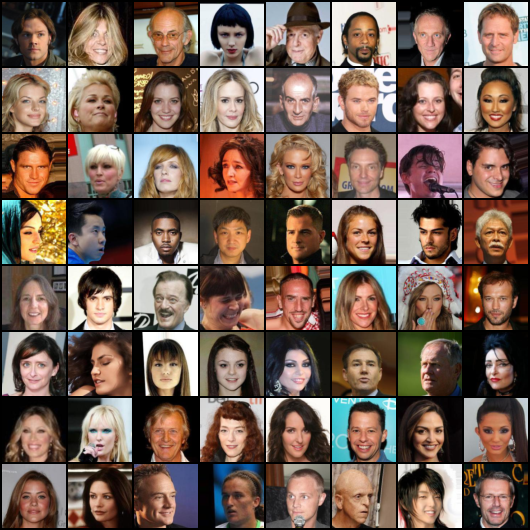

In [ ]:
# Saving real images first
real_batch = next(iter(dataloader))

for images, _ in dataloader:
    save_image(make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True), os.path.join(sample_dir, 'real_images.png'), nrow=8)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

In [ ]:
def save_fake_images(index, latent_tensors, show=True):
  fake_images = Generator_model(latent_tensors)
  fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
  print("Saving", fake_fname)

  if show:
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, nz, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving fake_images-0000.png


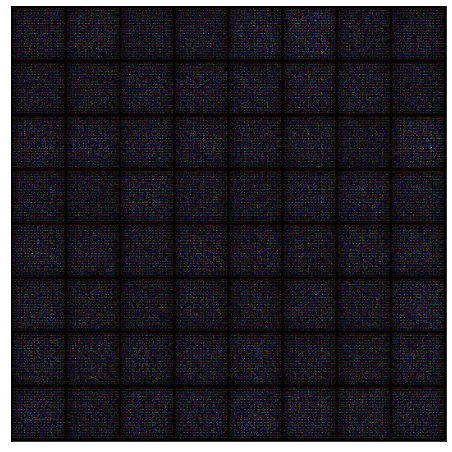

In [ ]:
save_fake_images(0, fixed_latent)

In [ ]:
from tqdm.notebook import tqdm, trange

In [ ]:
%%time

#Training the model now and saving fake images in the folder
total_step = len(dataloader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in tqdm(enumerate(dataloader),total=int(len(dataloader)),desc='epoch process'):
        # Load a batch & transform to vectors
        # images = images.reshape(batch_size, -1).to(device)
        # real_cpu = images[0].to(device)
        
        # Train the discriminator
       
        for parm in critic.parameters():
          parm.data.clamp_(-clamp_num, clamp_num)

        for c in range(critic_iter):
          d_loss, real_score, fake_score = train_discriminator(images.to(device))
       
        
       # Train generator
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item()) 
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1,fixed_latent,show=False)

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [0/10], Step [200/3166], d_loss: -1.5490, g_loss: 0.7355, D(x): 0.82, D(G(z)): -0.73
Epoch [0/10], Step [400/3166], d_loss: -1.3729, g_loss: 0.6703, D(x): 0.72, D(G(z)): -0.66
Epoch [0/10], Step [600/3166], d_loss: -1.3687, g_loss: 0.6752, D(x): 0.70, D(G(z)): -0.67
Epoch [0/10], Step [800/3166], d_loss: -1.4248, g_loss: 0.7016, D(x): 0.74, D(G(z)): -0.69
Epoch [0/10], Step [1000/3166], d_loss: -1.3988, g_loss: 0.7010, D(x): 0.73, D(G(z)): -0.67
Epoch [0/10], Step [1200/3166], d_loss: -1.3404, g_loss: 0.6526, D(x): 0.69, D(G(z)): -0.65
Epoch [0/10], Step [1400/3166], d_loss: -1.2825, g_loss: 0.6429, D(x): 0.67, D(G(z)): -0.61
Epoch [0/10], Step [1600/3166], d_loss: -1.3518, g_loss: 0.6703, D(x): 0.68, D(G(z)): -0.67
Epoch [0/10], Step [1800/3166], d_loss: -0.9609, g_loss: -0.4712, D(x): 0.27, D(G(z)): -0.69
Epoch [0/10], Step [2000/3166], d_loss: -1.2999, g_loss: 0.6520, D(x): 0.66, D(G(z)): -0.64
Epoch [0/10], Step [2200/3166], d_loss: -1.2846, g_loss: 0.6090, D(x): 0.65, D(G(z)

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [1/10], Step [200/3166], d_loss: -1.1992, g_loss: 0.5760, D(x): 0.62, D(G(z)): -0.58
Epoch [1/10], Step [400/3166], d_loss: -1.2416, g_loss: 0.6065, D(x): 0.60, D(G(z)): -0.64
Epoch [1/10], Step [600/3166], d_loss: -0.8381, g_loss: 0.6696, D(x): 0.58, D(G(z)): -0.26
Epoch [1/10], Step [800/3166], d_loss: -1.0784, g_loss: 0.6468, D(x): 0.68, D(G(z)): -0.40
Epoch [1/10], Step [1000/3166], d_loss: -1.1591, g_loss: 0.6241, D(x): 0.64, D(G(z)): -0.52
Epoch [1/10], Step [1200/3166], d_loss: -1.1711, g_loss: 0.5185, D(x): 0.57, D(G(z)): -0.61
Epoch [1/10], Step [1400/3166], d_loss: -0.9232, g_loss: 0.4109, D(x): 0.27, D(G(z)): -0.66
Epoch [1/10], Step [1600/3166], d_loss: -1.0476, g_loss: 0.6274, D(x): 0.66, D(G(z)): -0.39
Epoch [1/10], Step [1800/3166], d_loss: -1.1784, g_loss: 0.5916, D(x): 0.60, D(G(z)): -0.58
Epoch [1/10], Step [2000/3166], d_loss: -1.2181, g_loss: 0.6082, D(x): 0.61, D(G(z)): -0.60
Epoch [1/10], Step [2200/3166], d_loss: -0.6723, g_loss: 0.6408, D(x): 0.69, D(G(z))

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [2/10], Step [200/3166], d_loss: -0.8738, g_loss: 0.0245, D(x): 0.27, D(G(z)): -0.60
Epoch [2/10], Step [400/3166], d_loss: -0.7170, g_loss: 0.6191, D(x): 0.66, D(G(z)): -0.05
Epoch [2/10], Step [600/3166], d_loss: -1.0280, g_loss: 0.4580, D(x): 0.43, D(G(z)): -0.60
Epoch [2/10], Step [800/3166], d_loss: -1.0972, g_loss: 0.5930, D(x): 0.62, D(G(z)): -0.48
Epoch [2/10], Step [1000/3166], d_loss: -0.7996, g_loss: 0.2066, D(x): 0.16, D(G(z)): -0.63
Epoch [2/10], Step [1200/3166], d_loss: -0.9287, g_loss: 0.1225, D(x): 0.33, D(G(z)): -0.59
Epoch [2/10], Step [1400/3166], d_loss: -1.0319, g_loss: 0.5934, D(x): 0.63, D(G(z)): -0.40
Epoch [2/10], Step [1600/3166], d_loss: -0.9781, g_loss: 0.3349, D(x): 0.42, D(G(z)): -0.56
Epoch [2/10], Step [1800/3166], d_loss: -0.7903, g_loss: 0.0763, D(x): 0.24, D(G(z)): -0.55
Epoch [2/10], Step [2000/3166], d_loss: -0.9915, g_loss: 0.5401, D(x): 0.54, D(G(z)): -0.45
Epoch [2/10], Step [2200/3166], d_loss: -1.0330, g_loss: 0.5682, D(x): 0.62, D(G(z))

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [3/10], Step [200/3166], d_loss: -0.6919, g_loss: 0.1189, D(x): 0.16, D(G(z)): -0.54
Epoch [3/10], Step [400/3166], d_loss: -0.9043, g_loss: 0.3057, D(x): 0.33, D(G(z)): -0.57
Epoch [3/10], Step [600/3166], d_loss: -0.8914, g_loss: 0.5714, D(x): 0.59, D(G(z)): -0.30
Epoch [3/10], Step [800/3166], d_loss: -0.7599, g_loss: 0.5558, D(x): 0.65, D(G(z)): -0.11
Epoch [3/10], Step [1000/3166], d_loss: -0.8929, g_loss: 0.5231, D(x): 0.57, D(G(z)): -0.33
Epoch [3/10], Step [1200/3166], d_loss: -0.8427, g_loss: 0.2985, D(x): 0.34, D(G(z)): -0.50
Epoch [3/10], Step [1400/3166], d_loss: -0.8820, g_loss: 0.3286, D(x): 0.34, D(G(z)): -0.55
Epoch [3/10], Step [1600/3166], d_loss: -0.9095, g_loss: 0.5543, D(x): 0.60, D(G(z)): -0.31
Epoch [3/10], Step [1800/3166], d_loss: -0.9205, g_loss: 0.2511, D(x): 0.34, D(G(z)): -0.58
Epoch [3/10], Step [2000/3166], d_loss: -0.8345, g_loss: 0.2457, D(x): 0.28, D(G(z)): -0.55
Epoch [3/10], Step [2200/3166], d_loss: -0.7999, g_loss: 0.5746, D(x): 0.60, D(G(z))

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [4/10], Step [200/3166], d_loss: -0.6646, g_loss: 0.5733, D(x): 0.58, D(G(z)): -0.08
Epoch [4/10], Step [400/3166], d_loss: -0.8260, g_loss: 0.4737, D(x): 0.49, D(G(z)): -0.33
Epoch [4/10], Step [600/3166], d_loss: -0.7628, g_loss: 0.5359, D(x): 0.49, D(G(z)): -0.27
Epoch [4/10], Step [800/3166], d_loss: -0.6508, g_loss: 0.4988, D(x): 0.60, D(G(z)): -0.05
Epoch [4/10], Step [1000/3166], d_loss: -0.6678, g_loss: 0.5505, D(x): 0.59, D(G(z)): -0.08
Epoch [4/10], Step [1200/3166], d_loss: -0.7641, g_loss: 0.5304, D(x): 0.58, D(G(z)): -0.18
Epoch [4/10], Step [1400/3166], d_loss: -0.7032, g_loss: 0.5484, D(x): 0.49, D(G(z)): -0.21
Epoch [4/10], Step [1600/3166], d_loss: -0.7192, g_loss: 0.1198, D(x): 0.21, D(G(z)): -0.50
Epoch [4/10], Step [1800/3166], d_loss: -0.7176, g_loss: 0.5253, D(x): 0.57, D(G(z)): -0.14
Epoch [4/10], Step [2000/3166], d_loss: -0.7385, g_loss: 0.2050, D(x): 0.25, D(G(z)): -0.49
Epoch [4/10], Step [2200/3166], d_loss: -0.7155, g_loss: 0.2006, D(x): 0.21, D(G(z))

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [5/10], Step [200/3166], d_loss: -0.7263, g_loss: 0.5284, D(x): 0.60, D(G(z)): -0.13
Epoch [5/10], Step [400/3166], d_loss: -0.6577, g_loss: 0.0724, D(x): 0.15, D(G(z)): -0.51
Epoch [5/10], Step [600/3166], d_loss: -0.5765, g_loss: 0.4569, D(x): 0.57, D(G(z)): -0.01
Epoch [5/10], Step [800/3166], d_loss: -0.6228, g_loss: 0.1043, D(x): 0.17, D(G(z)): -0.46
Epoch [5/10], Step [1000/3166], d_loss: -0.7007, g_loss: 0.5122, D(x): 0.52, D(G(z)): -0.18
Epoch [5/10], Step [1200/3166], d_loss: -0.7567, g_loss: 0.2208, D(x): 0.32, D(G(z)): -0.43
Epoch [5/10], Step [1400/3166], d_loss: -0.6948, g_loss: 0.5240, D(x): 0.53, D(G(z)): -0.17
Epoch [5/10], Step [1600/3166], d_loss: -0.6425, g_loss: 0.4980, D(x): 0.52, D(G(z)): -0.12
Epoch [5/10], Step [1800/3166], d_loss: -0.5947, g_loss: 0.0418, D(x): 0.11, D(G(z)): -0.49
Epoch [5/10], Step [2000/3166], d_loss: -0.5591, g_loss: 0.5002, D(x): 0.59, D(G(z)): 0.03
Epoch [5/10], Step [2200/3166], d_loss: -0.5781, g_loss: 0.5118, D(x): 0.49, D(G(z)):

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [6/10], Step [200/3166], d_loss: -0.5547, g_loss: 0.5214, D(x): 0.54, D(G(z)): -0.02
Epoch [6/10], Step [400/3166], d_loss: -0.3055, g_loss: 0.5011, D(x): 0.57, D(G(z)): 0.27
Epoch [6/10], Step [600/3166], d_loss: -0.5865, g_loss: 0.4016, D(x): 0.55, D(G(z)): -0.04
Epoch [6/10], Step [800/3166], d_loss: -0.6136, g_loss: 0.2088, D(x): 0.18, D(G(z)): -0.44
Epoch [6/10], Step [1000/3166], d_loss: -0.6408, g_loss: 0.5023, D(x): 0.46, D(G(z)): -0.18
Epoch [6/10], Step [1200/3166], d_loss: -0.5757, g_loss: 0.1153, D(x): 0.11, D(G(z)): -0.47
Epoch [6/10], Step [1400/3166], d_loss: -0.4805, g_loss: 0.5335, D(x): 0.56, D(G(z)): 0.08
Epoch [6/10], Step [1600/3166], d_loss: -0.6066, g_loss: 0.0700, D(x): 0.17, D(G(z)): -0.43
Epoch [6/10], Step [1800/3166], d_loss: -0.6363, g_loss: 0.0723, D(x): 0.12, D(G(z)): -0.52
Epoch [6/10], Step [2000/3166], d_loss: -0.5059, g_loss: 0.4635, D(x): 0.60, D(G(z)): 0.09
Epoch [6/10], Step [2200/3166], d_loss: -0.5756, g_loss: 0.0047, D(x): 0.09, D(G(z)): -

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [7/10], Step [200/3166], d_loss: -0.5681, g_loss: 0.4867, D(x): 0.48, D(G(z)): -0.09
Epoch [7/10], Step [400/3166], d_loss: -0.5705, g_loss: 0.0059, D(x): 0.12, D(G(z)): -0.45
Epoch [7/10], Step [600/3166], d_loss: -0.6345, g_loss: -0.0436, D(x): 0.13, D(G(z)): -0.51
Epoch [7/10], Step [800/3166], d_loss: -0.5988, g_loss: 0.2615, D(x): 0.31, D(G(z)): -0.29
Epoch [7/10], Step [1000/3166], d_loss: -0.5250, g_loss: 0.0162, D(x): 0.02, D(G(z)): -0.51
Epoch [7/10], Step [1200/3166], d_loss: -0.6429, g_loss: 0.2423, D(x): 0.30, D(G(z)): -0.35
Epoch [7/10], Step [1400/3166], d_loss: -0.4866, g_loss: -0.0968, D(x): -0.01, D(G(z)): -0.50
Epoch [7/10], Step [1600/3166], d_loss: -0.5243, g_loss: 0.0590, D(x): 0.07, D(G(z)): -0.46
Epoch [7/10], Step [1800/3166], d_loss: -0.5661, g_loss: 0.4756, D(x): 0.54, D(G(z)): -0.02
Epoch [7/10], Step [2000/3166], d_loss: -0.5374, g_loss: 0.4962, D(x): 0.60, D(G(z)): 0.06
Epoch [7/10], Step [2200/3166], d_loss: -0.5355, g_loss: 0.4778, D(x): 0.43, D(G(z

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [8/10], Step [200/3166], d_loss: -0.5656, g_loss: 0.4751, D(x): 0.44, D(G(z)): -0.13
Epoch [8/10], Step [400/3166], d_loss: -0.4096, g_loss: 0.4527, D(x): 0.58, D(G(z)): 0.17
Epoch [8/10], Step [600/3166], d_loss: -0.6162, g_loss: 0.4938, D(x): 0.55, D(G(z)): -0.07
Epoch [8/10], Step [800/3166], d_loss: -0.7264, g_loss: 0.4800, D(x): 0.50, D(G(z)): -0.22
Epoch [8/10], Step [1000/3166], d_loss: -0.3908, g_loss: 0.4965, D(x): 0.59, D(G(z)): 0.20
Epoch [8/10], Step [1200/3166], d_loss: -0.5084, g_loss: 0.3748, D(x): 0.40, D(G(z)): -0.11
Epoch [8/10], Step [1400/3166], d_loss: -0.6131, g_loss: 0.3828, D(x): 0.32, D(G(z)): -0.29
Epoch [8/10], Step [1600/3166], d_loss: -0.6023, g_loss: 0.0629, D(x): 0.06, D(G(z)): -0.54
Epoch [8/10], Step [1800/3166], d_loss: -0.4832, g_loss: 0.0156, D(x): 0.19, D(G(z)): -0.29
Epoch [8/10], Step [2000/3166], d_loss: -0.5001, g_loss: 0.0969, D(x): 0.16, D(G(z)): -0.34
Epoch [8/10], Step [2200/3166], d_loss: -0.5774, g_loss: 0.4445, D(x): 0.41, D(G(z)): 

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [9/10], Step [200/3166], d_loss: -0.5039, g_loss: -0.1774, D(x): 0.03, D(G(z)): -0.48
Epoch [9/10], Step [400/3166], d_loss: -0.3597, g_loss: 0.5168, D(x): 0.61, D(G(z)): 0.25
Epoch [9/10], Step [600/3166], d_loss: -0.5166, g_loss: -0.4944, D(x): 0.00, D(G(z)): -0.51
Epoch [9/10], Step [800/3166], d_loss: -0.2814, g_loss: 0.3943, D(x): 0.59, D(G(z)): 0.31
Epoch [9/10], Step [1000/3166], d_loss: -0.4673, g_loss: 0.4953, D(x): 0.52, D(G(z)): 0.05
Epoch [9/10], Step [1200/3166], d_loss: -0.5524, g_loss: 0.3912, D(x): 0.33, D(G(z)): -0.23
Epoch [9/10], Step [1400/3166], d_loss: -0.7685, g_loss: 0.5807, D(x): 0.55, D(G(z)): -0.22
Epoch [9/10], Step [1600/3166], d_loss: -0.7282, g_loss: 0.6011, D(x): 0.64, D(G(z)): -0.08
Epoch [9/10], Step [1800/3166], d_loss: -0.7078, g_loss: 0.3610, D(x): 0.40, D(G(z)): -0.31
Epoch [9/10], Step [2000/3166], d_loss: -0.4967, g_loss: -0.0134, D(x): 0.03, D(G(z)): -0.47
Epoch [9/10], Step [2200/3166], d_loss: -0.8661, g_loss: -0.0130, D(x): 0.34, D(G(z)

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [10/10], Step [200/3166], d_loss: -0.2991, g_loss: 0.2232, D(x): 0.18, D(G(z)): -0.12
Epoch [10/10], Step [400/3166], d_loss: -0.5062, g_loss: -0.3413, D(x): 0.03, D(G(z)): -0.47
Epoch [10/10], Step [600/3166], d_loss: -0.1527, g_loss: 0.3511, D(x): 0.36, D(G(z)): 0.21
Epoch [10/10], Step [800/3166], d_loss: -0.4136, g_loss: 0.3956, D(x): 0.54, D(G(z)): 0.13
Epoch [10/10], Step [1000/3166], d_loss: -0.5184, g_loss: -0.2169, D(x): 0.04, D(G(z)): -0.48
Epoch [10/10], Step [1200/3166], d_loss: -0.4705, g_loss: -0.1524, D(x): 0.10, D(G(z)): -0.37
Epoch [10/10], Step [1400/3166], d_loss: -0.7141, g_loss: -0.1875, D(x): 0.14, D(G(z)): -0.58
Epoch [10/10], Step [1600/3166], d_loss: -0.4876, g_loss: 0.5557, D(x): 0.43, D(G(z)): -0.06
Epoch [10/10], Step [1800/3166], d_loss: -0.7658, g_loss: 0.3547, D(x): 0.45, D(G(z)): -0.32
Epoch [10/10], Step [2000/3166], d_loss: -0.4268, g_loss: 0.4460, D(x): 0.37, D(G(z)): -0.05
Epoch [10/10], Step [2200/3166], d_loss: -0.5185, g_loss: 0.5602, D(x): 

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [11/10], Step [200/3166], d_loss: -0.5668, g_loss: 0.5268, D(x): 0.52, D(G(z)): -0.05
Epoch [11/10], Step [400/3166], d_loss: -0.7803, g_loss: 0.0437, D(x): 0.40, D(G(z)): -0.38
Epoch [11/10], Step [600/3166], d_loss: -0.5540, g_loss: 0.2196, D(x): 0.21, D(G(z)): -0.35
Epoch [11/10], Step [800/3166], d_loss: -0.6105, g_loss: -0.0659, D(x): 0.23, D(G(z)): -0.38
Epoch [11/10], Step [1000/3166], d_loss: -0.4201, g_loss: 0.0772, D(x): 0.07, D(G(z)): -0.35
Epoch [11/10], Step [1200/3166], d_loss: -0.1990, g_loss: 0.0467, D(x): -0.21, D(G(z)): -0.41
Epoch [11/10], Step [1400/3166], d_loss: -0.0045, g_loss: 0.5826, D(x): -0.58, D(G(z)): -0.59
Epoch [11/10], Step [1600/3166], d_loss: -0.5446, g_loss: 0.0534, D(x): 0.28, D(G(z)): -0.27
Epoch [11/10], Step [1800/3166], d_loss: -0.6265, g_loss: 0.5193, D(x): 0.47, D(G(z)): -0.16
Epoch [11/10], Step [2000/3166], d_loss: -0.5953, g_loss: 0.2777, D(x): 0.34, D(G(z)): -0.25
Epoch [11/10], Step [2200/3166], d_loss: -0.4684, g_loss: 0.3252, D(x):

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [12/10], Step [200/3166], d_loss: -0.4759, g_loss: 0.2778, D(x): 0.25, D(G(z)): -0.22
Epoch [12/10], Step [400/3166], d_loss: -0.5229, g_loss: 0.2973, D(x): 0.64, D(G(z)): 0.12
Epoch [12/10], Step [600/3166], d_loss: -0.6897, g_loss: 0.4711, D(x): 0.42, D(G(z)): -0.27
Epoch [12/10], Step [800/3166], d_loss: -0.4045, g_loss: 0.4268, D(x): 0.50, D(G(z)): 0.10
Epoch [12/10], Step [1000/3166], d_loss: -0.2171, g_loss: 0.1825, D(x): 0.54, D(G(z)): 0.32
Epoch [12/10], Step [1200/3166], d_loss: -0.6995, g_loss: 0.4818, D(x): 0.45, D(G(z)): -0.25
Epoch [12/10], Step [1400/3166], d_loss: -0.6003, g_loss: -0.0512, D(x): 0.20, D(G(z)): -0.40
Epoch [12/10], Step [1600/3166], d_loss: -0.2653, g_loss: 0.4467, D(x): 0.31, D(G(z)): 0.04
Epoch [12/10], Step [1800/3166], d_loss: -0.2830, g_loss: 0.2493, D(x): -0.04, D(G(z)): -0.32
Epoch [12/10], Step [2000/3166], d_loss: -0.3367, g_loss: -0.1917, D(x): 0.08, D(G(z)): -0.26
Epoch [12/10], Step [2200/3166], d_loss: -0.4466, g_loss: -0.4173, D(x): 0.

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [13/10], Step [200/3166], d_loss: -0.2203, g_loss: 0.3375, D(x): 0.59, D(G(z)): 0.37
Epoch [13/10], Step [400/3166], d_loss: -0.3686, g_loss: 0.0218, D(x): 0.09, D(G(z)): -0.28
Epoch [13/10], Step [600/3166], d_loss: -0.5752, g_loss: 0.4026, D(x): 0.38, D(G(z)): -0.19
Epoch [13/10], Step [800/3166], d_loss: -0.6267, g_loss: 0.5931, D(x): 0.55, D(G(z)): -0.08
Epoch [13/10], Step [1000/3166], d_loss: -0.3980, g_loss: -0.1115, D(x): 0.04, D(G(z)): -0.36
Epoch [13/10], Step [1200/3166], d_loss: -0.2565, g_loss: 0.2292, D(x): 0.11, D(G(z)): -0.15
Epoch [13/10], Step [1400/3166], d_loss: -0.4617, g_loss: 0.3956, D(x): 0.35, D(G(z)): -0.12
Epoch [13/10], Step [1600/3166], d_loss: -0.3402, g_loss: 0.3959, D(x): 0.49, D(G(z)): 0.15
Epoch [13/10], Step [1800/3166], d_loss: -0.4699, g_loss: 0.1968, D(x): 0.25, D(G(z)): -0.22
Epoch [13/10], Step [2000/3166], d_loss: -0.4843, g_loss: 0.4721, D(x): 0.45, D(G(z)): -0.04
Epoch [13/10], Step [2200/3166], d_loss: -0.4875, g_loss: -0.3735, D(x): -0

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [14/10], Step [200/3166], d_loss: -0.4918, g_loss: 0.1917, D(x): 0.20, D(G(z)): -0.29
Epoch [14/10], Step [400/3166], d_loss: -0.5202, g_loss: 0.1530, D(x): 0.28, D(G(z)): -0.24
Epoch [14/10], Step [600/3166], d_loss: -0.3016, g_loss: 0.2171, D(x): 0.19, D(G(z)): -0.11
Epoch [14/10], Step [800/3166], d_loss: -0.3713, g_loss: 0.3527, D(x): 0.31, D(G(z)): -0.06
Epoch [14/10], Step [1000/3166], d_loss: -0.4280, g_loss: -0.0780, D(x): 0.02, D(G(z)): -0.41
Epoch [14/10], Step [1200/3166], d_loss: -0.3314, g_loss: 0.3429, D(x): 0.02, D(G(z)): -0.31
Epoch [14/10], Step [1400/3166], d_loss: -0.2144, g_loss: 0.4142, D(x): 0.40, D(G(z)): 0.19
Epoch [14/10], Step [1600/3166], d_loss: -0.1832, g_loss: 0.1354, D(x): 0.45, D(G(z)): 0.26
Epoch [14/10], Step [1800/3166], d_loss: -0.3331, g_loss: -0.1878, D(x): 0.07, D(G(z)): -0.27
Epoch [14/10], Step [2000/3166], d_loss: -0.2186, g_loss: 0.4181, D(x): 0.44, D(G(z)): 0.22
Epoch [14/10], Step [2200/3166], d_loss: -0.5823, g_loss: -0.0104, D(x): 0.

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [15/10], Step [200/3166], d_loss: -0.3124, g_loss: 0.4061, D(x): 0.34, D(G(z)): 0.02
Epoch [15/10], Step [400/3166], d_loss: -0.3203, g_loss: -0.0470, D(x): 0.03, D(G(z)): -0.29
Epoch [15/10], Step [600/3166], d_loss: -0.2690, g_loss: 0.4481, D(x): 0.28, D(G(z)): 0.01
Epoch [15/10], Step [800/3166], d_loss: -0.3943, g_loss: 0.3175, D(x): 0.23, D(G(z)): -0.17
Epoch [15/10], Step [1000/3166], d_loss: -0.1622, g_loss: -0.1691, D(x): 0.50, D(G(z)): 0.33
Epoch [15/10], Step [1200/3166], d_loss: -0.3996, g_loss: 0.5461, D(x): 0.56, D(G(z)): 0.16
Epoch [15/10], Step [1400/3166], d_loss: -0.1918, g_loss: 0.3166, D(x): -0.22, D(G(z)): -0.41
Epoch [15/10], Step [1600/3166], d_loss: -0.3670, g_loss: 0.4939, D(x): 0.49, D(G(z)): 0.13
Epoch [15/10], Step [1800/3166], d_loss: -0.1621, g_loss: 0.2648, D(x): -0.02, D(G(z)): -0.18
Epoch [15/10], Step [2000/3166], d_loss: -0.3264, g_loss: 0.2705, D(x): 0.19, D(G(z)): -0.13
Epoch [15/10], Step [2200/3166], d_loss: -0.1170, g_loss: -0.3194, D(x): 0.

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [16/10], Step [200/3166], d_loss: -0.2043, g_loss: 0.1984, D(x): 0.18, D(G(z)): -0.02
Epoch [16/10], Step [400/3166], d_loss: -0.1956, g_loss: 0.0768, D(x): 0.22, D(G(z)): 0.03
Epoch [16/10], Step [600/3166], d_loss: -0.4673, g_loss: 0.4749, D(x): 0.49, D(G(z)): 0.02
Epoch [16/10], Step [800/3166], d_loss: -0.6060, g_loss: -0.2521, D(x): 0.13, D(G(z)): -0.48
Epoch [16/10], Step [1000/3166], d_loss: -0.0421, g_loss: 0.5541, D(x): -0.52, D(G(z)): -0.57
Epoch [16/10], Step [1200/3166], d_loss: -0.5661, g_loss: 0.2921, D(x): 0.35, D(G(z)): -0.22
Epoch [16/10], Step [1400/3166], d_loss: -0.4126, g_loss: 0.0242, D(x): 0.17, D(G(z)): -0.24
Epoch [16/10], Step [1600/3166], d_loss: -0.3577, g_loss: 0.3743, D(x): 0.39, D(G(z)): 0.03
Epoch [16/10], Step [1800/3166], d_loss: -0.4012, g_loss: 0.0047, D(x): 0.04, D(G(z)): -0.37
Epoch [16/10], Step [2000/3166], d_loss: -0.0055, g_loss: 0.5191, D(x): -0.51, D(G(z)): -0.52
Epoch [16/10], Step [2200/3166], d_loss: -0.6006, g_loss: 0.1589, D(x): 0.

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [17/10], Step [200/3166], d_loss: -0.0698, g_loss: -0.4721, D(x): 0.50, D(G(z)): 0.43
Epoch [17/10], Step [400/3166], d_loss: -0.3787, g_loss: 0.0290, D(x): 0.15, D(G(z)): -0.23
Epoch [17/10], Step [600/3166], d_loss: -0.0934, g_loss: 0.3396, D(x): -0.22, D(G(z)): -0.32
Epoch [17/10], Step [800/3166], d_loss: -0.0513, g_loss: 0.4766, D(x): -0.44, D(G(z)): -0.49
Epoch [17/10], Step [1000/3166], d_loss: -0.3345, g_loss: 0.0694, D(x): 0.13, D(G(z)): -0.20
Epoch [17/10], Step [1200/3166], d_loss: -0.2355, g_loss: 0.1163, D(x): -0.29, D(G(z)): -0.53
Epoch [17/10], Step [1400/3166], d_loss: -0.2815, g_loss: 0.2865, D(x): 0.22, D(G(z)): -0.06
Epoch [17/10], Step [1600/3166], d_loss: -0.3119, g_loss: 0.4528, D(x): 0.51, D(G(z)): 0.19
Epoch [17/10], Step [1800/3166], d_loss: -0.3641, g_loss: 0.2193, D(x): 0.03, D(G(z)): -0.33
Epoch [17/10], Step [2000/3166], d_loss: -0.3133, g_loss: 0.3119, D(x): 0.43, D(G(z)): 0.12
Epoch [17/10], Step [2200/3166], d_loss: -0.4051, g_loss: 0.4957, D(x): 0

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [18/10], Step [200/3166], d_loss: -0.0455, g_loss: 0.2119, D(x): -0.23, D(G(z)): -0.27
Epoch [18/10], Step [400/3166], d_loss: -0.1629, g_loss: 0.3671, D(x): 0.19, D(G(z)): 0.03
Epoch [18/10], Step [600/3166], d_loss: -0.2385, g_loss: 0.4186, D(x): 0.58, D(G(z)): 0.34
Epoch [18/10], Step [800/3166], d_loss: -0.2866, g_loss: 0.3600, D(x): 0.25, D(G(z)): -0.04
Epoch [18/10], Step [1000/3166], d_loss: -0.4264, g_loss: 0.0771, D(x): 0.18, D(G(z)): -0.24
Epoch [18/10], Step [1200/3166], d_loss: -0.0517, g_loss: 0.4588, D(x): -0.45, D(G(z)): -0.50
Epoch [18/10], Step [1400/3166], d_loss: -0.0253, g_loss: -0.0033, D(x): 0.08, D(G(z)): 0.05
Epoch [18/10], Step [1600/3166], d_loss: -0.0077, g_loss: 0.5187, D(x): -0.52, D(G(z)): -0.53
Epoch [18/10], Step [1800/3166], d_loss: -0.1160, g_loss: -0.2180, D(x): 0.56, D(G(z)): 0.44
Epoch [18/10], Step [2000/3166], d_loss: -0.0118, g_loss: 0.5691, D(x): -0.53, D(G(z)): -0.54
Epoch [18/10], Step [2200/3166], d_loss: -0.1408, g_loss: 0.0369, D(x): 

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [19/10], Step [200/3166], d_loss: -0.0788, g_loss: 0.2596, D(x): -0.24, D(G(z)): -0.32
Epoch [19/10], Step [400/3166], d_loss: -0.0723, g_loss: -0.0579, D(x): 0.03, D(G(z)): -0.04
Epoch [19/10], Step [600/3166], d_loss: -0.0005, g_loss: 0.2228, D(x): -0.16, D(G(z)): -0.16
Epoch [19/10], Step [800/3166], d_loss: -0.0058, g_loss: 0.5416, D(x): -0.51, D(G(z)): -0.52
Epoch [19/10], Step [1000/3166], d_loss: 0.0211, g_loss: -0.6102, D(x): 0.60, D(G(z)): 0.63
Epoch [19/10], Step [1200/3166], d_loss: -0.0913, g_loss: 0.1363, D(x): -0.12, D(G(z)): -0.21
Epoch [19/10], Step [1400/3166], d_loss: 0.0053, g_loss: 0.5588, D(x): -0.54, D(G(z)): -0.53
Epoch [19/10], Step [1600/3166], d_loss: 0.1016, g_loss: 0.6259, D(x): -0.62, D(G(z)): -0.52
Epoch [19/10], Step [1800/3166], d_loss: -0.2894, g_loss: 0.1067, D(x): 0.20, D(G(z)): -0.09
Epoch [19/10], Step [2000/3166], d_loss: -0.0446, g_loss: 0.4554, D(x): -0.53, D(G(z)): -0.57
Epoch [19/10], Step [2200/3166], d_loss: -0.0197, g_loss: 0.5316, D(x

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [20/10], Step [200/3166], d_loss: -0.1703, g_loss: 0.0820, D(x): 0.12, D(G(z)): -0.05
Epoch [20/10], Step [400/3166], d_loss: -0.5527, g_loss: 0.1852, D(x): 0.02, D(G(z)): -0.54
Epoch [20/10], Step [600/3166], d_loss: -0.1545, g_loss: -0.2501, D(x): 0.34, D(G(z)): 0.19
Epoch [20/10], Step [800/3166], d_loss: -0.1570, g_loss: 0.0486, D(x): -0.12, D(G(z)): -0.28
Epoch [20/10], Step [1000/3166], d_loss: -0.0400, g_loss: 0.4447, D(x): -0.42, D(G(z)): -0.46
Epoch [20/10], Step [1200/3166], d_loss: -0.7494, g_loss: 0.3511, D(x): 0.47, D(G(z)): -0.28
Epoch [20/10], Step [1400/3166], d_loss: -0.4599, g_loss: -0.4944, D(x): 0.25, D(G(z)): -0.21
Epoch [20/10], Step [1600/3166], d_loss: -0.0937, g_loss: -0.0886, D(x): 0.12, D(G(z)): 0.03
Epoch [20/10], Step [1800/3166], d_loss: -0.0027, g_loss: -0.4997, D(x): 0.49, D(G(z)): 0.49
Epoch [20/10], Step [2000/3166], d_loss: -0.0614, g_loss: 0.4509, D(x): -0.32, D(G(z)): -0.39
Epoch [20/10], Step [2200/3166], d_loss: -0.0355, g_loss: -0.4771, D(x

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [21/10], Step [200/3166], d_loss: -0.0576, g_loss: 0.5465, D(x): -0.54, D(G(z)): -0.60
Epoch [21/10], Step [400/3166], d_loss: 0.0149, g_loss: -0.4268, D(x): 0.44, D(G(z)): 0.45
Epoch [21/10], Step [600/3166], d_loss: -0.6311, g_loss: -0.4179, D(x): 0.16, D(G(z)): -0.47
Epoch [21/10], Step [800/3166], d_loss: -0.0617, g_loss: -0.3498, D(x): 0.50, D(G(z)): 0.44
Epoch [21/10], Step [1000/3166], d_loss: -0.0707, g_loss: -0.3839, D(x): 0.58, D(G(z)): 0.51
Epoch [21/10], Step [1200/3166], d_loss: -0.0256, g_loss: -0.4341, D(x): 0.44, D(G(z)): 0.42
Epoch [21/10], Step [1400/3166], d_loss: 0.0227, g_loss: -0.6309, D(x): 0.59, D(G(z)): 0.61
Epoch [21/10], Step [1600/3166], d_loss: -0.1894, g_loss: -0.2849, D(x): 0.38, D(G(z)): 0.19
Epoch [21/10], Step [1800/3166], d_loss: -0.0951, g_loss: 0.4979, D(x): -0.39, D(G(z)): -0.48
Epoch [21/10], Step [2000/3166], d_loss: -0.2688, g_loss: 0.3926, D(x): -0.09, D(G(z)): -0.36
Epoch [21/10], Step [2200/3166], d_loss: 0.0116, g_loss: -0.5356, D(x): 

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [22/10], Step [200/3166], d_loss: -0.0728, g_loss: -0.0783, D(x): 0.19, D(G(z)): 0.11
Epoch [22/10], Step [400/3166], d_loss: -0.2928, g_loss: 0.2614, D(x): -0.01, D(G(z)): -0.30
Epoch [22/10], Step [600/3166], d_loss: -0.3890, g_loss: 0.0465, D(x): 0.16, D(G(z)): -0.23
Epoch [22/10], Step [800/3166], d_loss: -0.0164, g_loss: 0.3199, D(x): -0.34, D(G(z)): -0.36
Epoch [22/10], Step [1000/3166], d_loss: -0.1770, g_loss: 0.5602, D(x): -0.22, D(G(z)): -0.40
Epoch [22/10], Step [1200/3166], d_loss: -0.0010, g_loss: 0.4500, D(x): -0.48, D(G(z)): -0.48
Epoch [22/10], Step [1400/3166], d_loss: -0.1075, g_loss: 0.3515, D(x): 0.22, D(G(z)): 0.12
Epoch [22/10], Step [1600/3166], d_loss: -0.1987, g_loss: -0.0634, D(x): 0.23, D(G(z)): 0.03
Epoch [22/10], Step [1800/3166], d_loss: -0.1387, g_loss: 0.3869, D(x): -0.29, D(G(z)): -0.43
Epoch [22/10], Step [2000/3166], d_loss: -0.2517, g_loss: -0.0996, D(x): -0.03, D(G(z)): -0.29
Epoch [22/10], Step [2200/3166], d_loss: -0.2626, g_loss: 0.5877, D(

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [23/10], Step [200/3166], d_loss: -0.7569, g_loss: 0.6249, D(x): 0.62, D(G(z)): -0.13
Epoch [23/10], Step [400/3166], d_loss: -0.1006, g_loss: -0.5089, D(x): 0.60, D(G(z)): 0.49
Epoch [23/10], Step [600/3166], d_loss: -0.0590, g_loss: 0.4508, D(x): -0.33, D(G(z)): -0.39
Epoch [23/10], Step [800/3166], d_loss: -0.6722, g_loss: 0.1026, D(x): 0.32, D(G(z)): -0.35
Epoch [23/10], Step [1000/3166], d_loss: -0.3538, g_loss: 0.1385, D(x): 0.23, D(G(z)): -0.12
Epoch [23/10], Step [1200/3166], d_loss: -0.0509, g_loss: -0.3498, D(x): 0.41, D(G(z)): 0.36
Epoch [23/10], Step [1400/3166], d_loss: -0.0077, g_loss: 0.4638, D(x): -0.42, D(G(z)): -0.43
Epoch [23/10], Step [1600/3166], d_loss: -0.1016, g_loss: 0.1554, D(x): -0.10, D(G(z)): -0.20
Epoch [23/10], Step [1800/3166], d_loss: -0.0119, g_loss: -0.5987, D(x): 0.63, D(G(z)): 0.61
Epoch [23/10], Step [2000/3166], d_loss: -0.7999, g_loss: 0.5279, D(x): 0.59, D(G(z)): -0.21
Epoch [23/10], Step [2200/3166], d_loss: -0.0097, g_loss: 0.5555, D(x):

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [24/10], Step [200/3166], d_loss: -0.2899, g_loss: 0.1950, D(x): 0.24, D(G(z)): -0.05
Epoch [24/10], Step [400/3166], d_loss: -0.0325, g_loss: -0.1937, D(x): 0.52, D(G(z)): 0.49
Epoch [24/10], Step [600/3166], d_loss: -0.1413, g_loss: 0.5750, D(x): -0.40, D(G(z)): -0.54
Epoch [24/10], Step [800/3166], d_loss: -0.6742, g_loss: -0.3981, D(x): 0.13, D(G(z)): -0.54
Epoch [24/10], Step [1000/3166], d_loss: -0.1897, g_loss: -0.0353, D(x): 0.12, D(G(z)): -0.06
Epoch [24/10], Step [1200/3166], d_loss: -0.3912, g_loss: 0.2108, D(x): 0.34, D(G(z)): -0.05
Epoch [24/10], Step [1400/3166], d_loss: 0.0479, g_loss: 0.1367, D(x): -0.08, D(G(z)): -0.04
Epoch [24/10], Step [1600/3166], d_loss: 0.0256, g_loss: 0.6119, D(x): -0.58, D(G(z)): -0.55
Epoch [24/10], Step [1800/3166], d_loss: -0.0323, g_loss: -0.3770, D(x): 0.41, D(G(z)): 0.38
Epoch [24/10], Step [2000/3166], d_loss: -0.0446, g_loss: -0.5704, D(x): 0.66, D(G(z)): 0.61
Epoch [24/10], Step [2200/3166], d_loss: -0.3082, g_loss: 0.4965, D(x):

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [25/10], Step [200/3166], d_loss: -0.0024, g_loss: 0.5811, D(x): -0.56, D(G(z)): -0.56
Epoch [25/10], Step [400/3166], d_loss: -0.1425, g_loss: 0.3556, D(x): 0.18, D(G(z)): 0.04
Epoch [25/10], Step [600/3166], d_loss: -0.2177, g_loss: -0.0685, D(x): 0.31, D(G(z)): 0.10
Epoch [25/10], Step [800/3166], d_loss: -0.2353, g_loss: -0.3758, D(x): 0.38, D(G(z)): 0.15
Epoch [25/10], Step [1000/3166], d_loss: -0.1559, g_loss: 0.2133, D(x): 0.17, D(G(z)): 0.02
Epoch [25/10], Step [1200/3166], d_loss: -0.8238, g_loss: 0.1832, D(x): 0.70, D(G(z)): -0.12
Epoch [25/10], Step [1400/3166], d_loss: 0.0122, g_loss: 0.4392, D(x): -0.28, D(G(z)): -0.27
Epoch [25/10], Step [1600/3166], d_loss: -0.2602, g_loss: 0.2088, D(x): 0.05, D(G(z)): -0.21
Epoch [25/10], Step [1800/3166], d_loss: -0.2063, g_loss: 0.4984, D(x): 0.46, D(G(z)): 0.26
Epoch [25/10], Step [2000/3166], d_loss: -1.2688, g_loss: 0.6302, D(x): 0.60, D(G(z)): -0.67
Epoch [25/10], Step [2200/3166], d_loss: -0.0689, g_loss: 0.4672, D(x): -0.4

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [26/10], Step [200/3166], d_loss: -0.2082, g_loss: 0.2294, D(x): -0.02, D(G(z)): -0.23
Epoch [26/10], Step [400/3166], d_loss: -0.0263, g_loss: -0.5805, D(x): 0.59, D(G(z)): 0.57
Epoch [26/10], Step [600/3166], d_loss: 0.1738, g_loss: -0.3950, D(x): 0.12, D(G(z)): 0.30
Epoch [26/10], Step [800/3166], d_loss: -0.0018, g_loss: 0.5431, D(x): -0.52, D(G(z)): -0.52
Epoch [26/10], Step [1000/3166], d_loss: -0.1145, g_loss: -0.2988, D(x): 0.59, D(G(z)): 0.47
Epoch [26/10], Step [1200/3166], d_loss: 0.1777, g_loss: 0.0140, D(x): -0.00, D(G(z)): 0.18
Epoch [26/10], Step [1400/3166], d_loss: -0.1765, g_loss: 0.4814, D(x): 0.53, D(G(z)): 0.36
Epoch [26/10], Step [1600/3166], d_loss: -0.3336, g_loss: 0.4681, D(x): -0.08, D(G(z)): -0.41
Epoch [26/10], Step [1800/3166], d_loss: -0.0416, g_loss: -0.3628, D(x): 0.41, D(G(z)): 0.37
Epoch [26/10], Step [2000/3166], d_loss: -0.1102, g_loss: -0.4324, D(x): 0.60, D(G(z)): 0.49
Epoch [26/10], Step [2200/3166], d_loss: -0.4513, g_loss: 0.1360, D(x): 0.

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [27/10], Step [200/3166], d_loss: -0.2547, g_loss: 0.1847, D(x): 0.38, D(G(z)): 0.13
Epoch [27/10], Step [400/3166], d_loss: -0.2712, g_loss: 0.2662, D(x): 0.23, D(G(z)): -0.04
Epoch [27/10], Step [600/3166], d_loss: -0.8124, g_loss: -0.2273, D(x): 0.26, D(G(z)): -0.55
Epoch [27/10], Step [800/3166], d_loss: -0.0589, g_loss: -0.2020, D(x): 0.31, D(G(z)): 0.25
Epoch [27/10], Step [1000/3166], d_loss: -0.0763, g_loss: -0.4230, D(x): 0.50, D(G(z)): 0.42
Epoch [27/10], Step [1200/3166], d_loss: -0.9436, g_loss: 0.6659, D(x): 0.61, D(G(z)): -0.33
Epoch [27/10], Step [1400/3166], d_loss: -0.6579, g_loss: 0.3432, D(x): 0.27, D(G(z)): -0.39
Epoch [27/10], Step [1600/3166], d_loss: -0.3418, g_loss: -0.1297, D(x): 0.53, D(G(z)): 0.19
Epoch [27/10], Step [1800/3166], d_loss: -0.3602, g_loss: 0.4835, D(x): 0.58, D(G(z)): 0.22
Epoch [27/10], Step [2000/3166], d_loss: -0.1564, g_loss: 0.4306, D(x): -0.41, D(G(z)): -0.57
Epoch [27/10], Step [2200/3166], d_loss: -0.6334, g_loss: 0.0459, D(x): 0.

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [28/10], Step [200/3166], d_loss: -0.0312, g_loss: 0.4929, D(x): -0.48, D(G(z)): -0.51
Epoch [28/10], Step [400/3166], d_loss: -0.2427, g_loss: -0.3071, D(x): 0.38, D(G(z)): 0.14
Epoch [28/10], Step [600/3166], d_loss: -1.0514, g_loss: -0.3889, D(x): 0.44, D(G(z)): -0.61
Epoch [28/10], Step [800/3166], d_loss: -0.1454, g_loss: 0.5544, D(x): -0.47, D(G(z)): -0.61
Epoch [28/10], Step [1000/3166], d_loss: -0.0653, g_loss: -0.4505, D(x): 0.54, D(G(z)): 0.48
Epoch [28/10], Step [1200/3166], d_loss: -0.3985, g_loss: 0.4114, D(x): -0.08, D(G(z)): -0.47
Epoch [28/10], Step [1400/3166], d_loss: -0.6008, g_loss: -0.0402, D(x): 0.16, D(G(z)): -0.44
Epoch [28/10], Step [1600/3166], d_loss: -1.3905, g_loss: 0.7316, D(x): 0.67, D(G(z)): -0.72
Epoch [28/10], Step [1800/3166], d_loss: -0.8387, g_loss: 0.4965, D(x): 0.37, D(G(z)): -0.47
Epoch [28/10], Step [2000/3166], d_loss: -0.0902, g_loss: -0.5288, D(x): 0.57, D(G(z)): 0.48
Epoch [28/10], Step [2200/3166], d_loss: -0.5079, g_loss: 0.3327, D(x

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [29/10], Step [200/3166], d_loss: -0.1351, g_loss: -0.0570, D(x): 0.19, D(G(z)): 0.05
Epoch [29/10], Step [400/3166], d_loss: -0.1473, g_loss: 0.5408, D(x): -0.41, D(G(z)): -0.56
Epoch [29/10], Step [600/3166], d_loss: -0.0309, g_loss: -0.0187, D(x): 0.18, D(G(z)): 0.15
Epoch [29/10], Step [800/3166], d_loss: -0.9408, g_loss: 0.5179, D(x): 0.47, D(G(z)): -0.47
Epoch [29/10], Step [1000/3166], d_loss: -0.3480, g_loss: 0.4857, D(x): -0.18, D(G(z)): -0.52
Epoch [29/10], Step [1200/3166], d_loss: 0.0089, g_loss: 0.3408, D(x): 0.08, D(G(z)): 0.09
Epoch [29/10], Step [1400/3166], d_loss: -0.1306, g_loss: -0.0022, D(x): 0.57, D(G(z)): 0.44
Epoch [29/10], Step [1600/3166], d_loss: -0.2096, g_loss: 0.2255, D(x): 0.07, D(G(z)): -0.14
Epoch [29/10], Step [1800/3166], d_loss: -0.0549, g_loss: 0.0109, D(x): 0.41, D(G(z)): 0.35
Epoch [29/10], Step [2000/3166], d_loss: -0.3652, g_loss: 0.1154, D(x): 0.21, D(G(z)): -0.16
Epoch [29/10], Step [2200/3166], d_loss: -0.0796, g_loss: 0.2141, D(x): -0.

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [30/10], Step [200/3166], d_loss: -0.1139, g_loss: 0.3311, D(x): -0.24, D(G(z)): -0.35
Epoch [30/10], Step [400/3166], d_loss: -0.2236, g_loss: 0.1893, D(x): 0.61, D(G(z)): 0.39
Epoch [30/10], Step [600/3166], d_loss: -0.5734, g_loss: 0.5862, D(x): 0.42, D(G(z)): -0.16
Epoch [30/10], Step [800/3166], d_loss: -0.2608, g_loss: 0.4743, D(x): -0.24, D(G(z)): -0.50
Epoch [30/10], Step [1000/3166], d_loss: -0.0841, g_loss: -0.4254, D(x): 0.47, D(G(z)): 0.38
Epoch [30/10], Step [1200/3166], d_loss: -1.0587, g_loss: 0.2561, D(x): 0.58, D(G(z)): -0.48
Epoch [30/10], Step [1400/3166], d_loss: -0.0269, g_loss: -0.2325, D(x): 0.48, D(G(z)): 0.46
Epoch [30/10], Step [1600/3166], d_loss: -0.0570, g_loss: 0.3452, D(x): -0.55, D(G(z)): -0.60
Epoch [30/10], Step [1800/3166], d_loss: -0.0159, g_loss: -0.6547, D(x): 0.68, D(G(z)): 0.66
Epoch [30/10], Step [2000/3166], d_loss: -0.4308, g_loss: 0.0918, D(x): 0.17, D(G(z)): -0.26
Epoch [30/10], Step [2200/3166], d_loss: -0.0922, g_loss: -0.3650, D(x):

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [31/10], Step [200/3166], d_loss: -0.8192, g_loss: 0.5735, D(x): 0.59, D(G(z)): -0.23
Epoch [31/10], Step [400/3166], d_loss: -0.2650, g_loss: 0.1297, D(x): 0.01, D(G(z)): -0.26
Epoch [31/10], Step [600/3166], d_loss: -0.4193, g_loss: -0.1876, D(x): 0.58, D(G(z)): 0.16
Epoch [31/10], Step [800/3166], d_loss: -0.4489, g_loss: -0.1388, D(x): 0.30, D(G(z)): -0.15
Epoch [31/10], Step [1000/3166], d_loss: -0.6560, g_loss: 0.5951, D(x): 0.36, D(G(z)): -0.29
Epoch [31/10], Step [1200/3166], d_loss: -0.0250, g_loss: 0.6327, D(x): -0.61, D(G(z)): -0.64
Epoch [31/10], Step [1400/3166], d_loss: -0.2484, g_loss: 0.2319, D(x): -0.01, D(G(z)): -0.26
Epoch [31/10], Step [1600/3166], d_loss: -0.1183, g_loss: -0.0032, D(x): 0.26, D(G(z)): 0.14
Epoch [31/10], Step [1800/3166], d_loss: -0.1724, g_loss: 0.4168, D(x): -0.33, D(G(z)): -0.51
Epoch [31/10], Step [2000/3166], d_loss: 0.0432, g_loss: 0.4205, D(x): -0.24, D(G(z)): -0.20
Epoch [31/10], Step [2200/3166], d_loss: -0.2344, g_loss: 0.1210, D(x)

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [32/10], Step [200/3166], d_loss: -0.6613, g_loss: -0.4259, D(x): 0.05, D(G(z)): -0.61
Epoch [32/10], Step [400/3166], d_loss: -0.3227, g_loss: -0.3103, D(x): 0.49, D(G(z)): 0.17
Epoch [32/10], Step [600/3166], d_loss: -0.4315, g_loss: 0.0418, D(x): 0.26, D(G(z)): -0.18
Epoch [32/10], Step [800/3166], d_loss: -0.0124, g_loss: 0.5096, D(x): -0.48, D(G(z)): -0.49
Epoch [32/10], Step [1000/3166], d_loss: -0.1436, g_loss: 0.1810, D(x): 0.26, D(G(z)): 0.11
Epoch [32/10], Step [1200/3166], d_loss: -0.9168, g_loss: 0.1086, D(x): 0.33, D(G(z)): -0.59
Epoch [32/10], Step [1400/3166], d_loss: -0.0160, g_loss: 0.5637, D(x): -0.57, D(G(z)): -0.59
Epoch [32/10], Step [1600/3166], d_loss: -0.0554, g_loss: 0.5863, D(x): -0.55, D(G(z)): -0.60
Epoch [32/10], Step [1800/3166], d_loss: -0.2077, g_loss: 0.0985, D(x): 0.40, D(G(z)): 0.19
Epoch [32/10], Step [2000/3166], d_loss: -0.1109, g_loss: -0.3167, D(x): 0.46, D(G(z)): 0.35
Epoch [32/10], Step [2200/3166], d_loss: 0.0689, g_loss: -0.6209, D(x): 

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [33/10], Step [200/3166], d_loss: -0.0603, g_loss: -0.1454, D(x): 0.49, D(G(z)): 0.43
Epoch [33/10], Step [400/3166], d_loss: -0.1313, g_loss: 0.5218, D(x): -0.39, D(G(z)): -0.52
Epoch [33/10], Step [600/3166], d_loss: -0.0923, g_loss: -0.5681, D(x): 0.67, D(G(z)): 0.57
Epoch [33/10], Step [800/3166], d_loss: -0.6305, g_loss: -0.3225, D(x): 0.23, D(G(z)): -0.40
Epoch [33/10], Step [1000/3166], d_loss: -0.0641, g_loss: -0.6153, D(x): 0.66, D(G(z)): 0.59
Epoch [33/10], Step [1200/3166], d_loss: 0.0508, g_loss: 0.1177, D(x): -0.07, D(G(z)): -0.02
Epoch [33/10], Step [1400/3166], d_loss: -0.0293, g_loss: 0.4975, D(x): -0.47, D(G(z)): -0.50
Epoch [33/10], Step [1600/3166], d_loss: -0.3934, g_loss: 0.6276, D(x): 0.28, D(G(z)): -0.11
Epoch [33/10], Step [1800/3166], d_loss: -0.1453, g_loss: 0.4926, D(x): -0.42, D(G(z)): -0.57
Epoch [33/10], Step [2000/3166], d_loss: -1.1579, g_loss: 0.6393, D(x): 0.57, D(G(z)): -0.58
Epoch [33/10], Step [2200/3166], d_loss: -0.0852, g_loss: -0.4457, D(x

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [34/10], Step [200/3166], d_loss: -0.0985, g_loss: -0.1753, D(x): 0.29, D(G(z)): 0.19
Epoch [34/10], Step [400/3166], d_loss: -0.7508, g_loss: -0.0768, D(x): 0.17, D(G(z)): -0.58
Epoch [34/10], Step [600/3166], d_loss: -0.2468, g_loss: 0.3745, D(x): 0.25, D(G(z)): 0.00
Epoch [34/10], Step [800/3166], d_loss: -0.0160, g_loss: 0.5687, D(x): -0.56, D(G(z)): -0.58
Epoch [34/10], Step [1000/3166], d_loss: -1.0016, g_loss: 0.6106, D(x): 0.64, D(G(z)): -0.36
Epoch [34/10], Step [1200/3166], d_loss: -0.0523, g_loss: -0.4987, D(x): 0.55, D(G(z)): 0.49
Epoch [34/10], Step [1400/3166], d_loss: -0.0536, g_loss: 0.4954, D(x): -0.50, D(G(z)): -0.55
Epoch [34/10], Step [1600/3166], d_loss: 0.0005, g_loss: -0.5050, D(x): 0.52, D(G(z)): 0.53
Epoch [34/10], Step [1800/3166], d_loss: -0.6279, g_loss: -0.5510, D(x): 0.66, D(G(z)): 0.03
Epoch [34/10], Step [2000/3166], d_loss: -0.0878, g_loss: 0.4143, D(x): -0.32, D(G(z)): -0.41
Epoch [34/10], Step [2200/3166], d_loss: 0.0827, g_loss: -0.0503, D(x): 

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [35/10], Step [200/3166], d_loss: -0.0502, g_loss: 0.6183, D(x): -0.59, D(G(z)): -0.64
Epoch [35/10], Step [400/3166], d_loss: -0.0574, g_loss: 0.3791, D(x): -0.28, D(G(z)): -0.34
Epoch [35/10], Step [600/3166], d_loss: -0.2496, g_loss: 0.0961, D(x): 0.28, D(G(z)): 0.03
Epoch [35/10], Step [800/3166], d_loss: -0.0625, g_loss: 0.3951, D(x): -0.40, D(G(z)): -0.46
Epoch [35/10], Step [1000/3166], d_loss: -0.0340, g_loss: 0.5842, D(x): -0.57, D(G(z)): -0.60
Epoch [35/10], Step [1200/3166], d_loss: -0.3854, g_loss: 0.4809, D(x): -0.18, D(G(z)): -0.57
Epoch [35/10], Step [1400/3166], d_loss: -0.0009, g_loss: -0.0767, D(x): 0.56, D(G(z)): 0.55
Epoch [35/10], Step [1600/3166], d_loss: -0.0843, g_loss: 0.3883, D(x): -0.38, D(G(z)): -0.47
Epoch [35/10], Step [1800/3166], d_loss: -0.3428, g_loss: 0.2649, D(x): 0.18, D(G(z)): -0.17
Epoch [35/10], Step [2000/3166], d_loss: 0.0855, g_loss: 0.6462, D(x): -0.63, D(G(z)): -0.54
Epoch [35/10], Step [2200/3166], d_loss: -0.4409, g_loss: 0.2118, D(x

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [36/10], Step [200/3166], d_loss: -0.0521, g_loss: -0.4821, D(x): 0.60, D(G(z)): 0.55
Epoch [36/10], Step [400/3166], d_loss: -0.4224, g_loss: 0.3727, D(x): -0.08, D(G(z)): -0.50
Epoch [36/10], Step [600/3166], d_loss: -0.6763, g_loss: -0.2013, D(x): 0.59, D(G(z)): -0.08
Epoch [36/10], Step [800/3166], d_loss: 0.0253, g_loss: -0.5019, D(x): 0.57, D(G(z)): 0.59
Epoch [36/10], Step [1000/3166], d_loss: -0.9978, g_loss: -0.2397, D(x): 0.46, D(G(z)): -0.54
Epoch [36/10], Step [1200/3166], d_loss: -0.2428, g_loss: 0.3920, D(x): -0.06, D(G(z)): -0.31
Epoch [36/10], Step [1400/3166], d_loss: -0.1462, g_loss: -0.0159, D(x): 0.17, D(G(z)): 0.02
Epoch [36/10], Step [1600/3166], d_loss: -0.0558, g_loss: 0.5927, D(x): -0.52, D(G(z)): -0.57
Epoch [36/10], Step [1800/3166], d_loss: -0.0720, g_loss: 0.1908, D(x): -0.15, D(G(z)): -0.23
Epoch [36/10], Step [2000/3166], d_loss: -0.0873, g_loss: -0.6441, D(x): 0.68, D(G(z)): 0.59
Epoch [36/10], Step [2200/3166], d_loss: -0.1010, g_loss: -0.1774, D(

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [37/10], Step [200/3166], d_loss: 0.0122, g_loss: -0.0358, D(x): -0.05, D(G(z)): -0.04
Epoch [37/10], Step [400/3166], d_loss: -0.3244, g_loss: 0.0835, D(x): -0.10, D(G(z)): -0.42
Epoch [37/10], Step [600/3166], d_loss: 0.0069, g_loss: 0.6169, D(x): -0.64, D(G(z)): -0.63
Epoch [37/10], Step [800/3166], d_loss: -0.5393, g_loss: 0.5355, D(x): 0.47, D(G(z)): -0.07
Epoch [37/10], Step [1000/3166], d_loss: -0.0137, g_loss: 0.5519, D(x): -0.55, D(G(z)): -0.57
Epoch [37/10], Step [1200/3166], d_loss: -0.8944, g_loss: -0.5943, D(x): 0.20, D(G(z)): -0.70
Epoch [37/10], Step [1400/3166], d_loss: -0.0381, g_loss: 0.5578, D(x): -0.51, D(G(z)): -0.55
Epoch [37/10], Step [1600/3166], d_loss: -0.0137, g_loss: -0.6222, D(x): 0.65, D(G(z)): 0.64
Epoch [37/10], Step [1800/3166], d_loss: -0.0592, g_loss: 0.4769, D(x): -0.49, D(G(z)): -0.55
Epoch [37/10], Step [2000/3166], d_loss: -0.5135, g_loss: 0.2378, D(x): 0.18, D(G(z)): -0.33
Epoch [37/10], Step [2200/3166], d_loss: -0.0210, g_loss: -0.5695, D

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [38/10], Step [200/3166], d_loss: -0.3368, g_loss: -0.4018, D(x): 0.11, D(G(z)): -0.23
Epoch [38/10], Step [400/3166], d_loss: -0.0007, g_loss: 0.5267, D(x): -0.50, D(G(z)): -0.50
Epoch [38/10], Step [600/3166], d_loss: -0.1866, g_loss: 0.0200, D(x): 0.04, D(G(z)): -0.15
Epoch [38/10], Step [800/3166], d_loss: -0.0104, g_loss: 0.6219, D(x): -0.62, D(G(z)): -0.63
Epoch [38/10], Step [1000/3166], d_loss: 0.0099, g_loss: 0.4824, D(x): -0.44, D(G(z)): -0.43
Epoch [38/10], Step [1200/3166], d_loss: -0.0397, g_loss: 0.6322, D(x): -0.60, D(G(z)): -0.63
Epoch [38/10], Step [1400/3166], d_loss: 0.0368, g_loss: -0.6447, D(x): 0.62, D(G(z)): 0.65
Epoch [38/10], Step [1600/3166], d_loss: -1.2377, g_loss: 0.6762, D(x): 0.63, D(G(z)): -0.61
Epoch [38/10], Step [1800/3166], d_loss: -0.4961, g_loss: 0.4308, D(x): 0.45, D(G(z)): -0.05
Epoch [38/10], Step [2000/3166], d_loss: -0.3756, g_loss: 0.5505, D(x): -0.13, D(G(z)): -0.51
Epoch [38/10], Step [2200/3166], d_loss: -0.2879, g_loss: -0.1935, D(x

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [39/10], Step [200/3166], d_loss: -0.0037, g_loss: -0.5398, D(x): 0.56, D(G(z)): 0.56
Epoch [39/10], Step [400/3166], d_loss: 0.0157, g_loss: -0.2877, D(x): 0.45, D(G(z)): 0.47
Epoch [39/10], Step [600/3166], d_loss: -0.2104, g_loss: -0.0897, D(x): 0.18, D(G(z)): -0.03
Epoch [39/10], Step [800/3166], d_loss: -0.1934, g_loss: 0.3740, D(x): 0.06, D(G(z)): -0.13
Epoch [39/10], Step [1000/3166], d_loss: -0.1222, g_loss: 0.3108, D(x): -0.26, D(G(z)): -0.39
Epoch [39/10], Step [1200/3166], d_loss: -0.5447, g_loss: 0.3336, D(x): 0.69, D(G(z)): 0.14
Epoch [39/10], Step [1400/3166], d_loss: -0.9442, g_loss: 0.5150, D(x): 0.41, D(G(z)): -0.53
Epoch [39/10], Step [1600/3166], d_loss: -0.0539, g_loss: 0.5966, D(x): -0.57, D(G(z)): -0.62
Epoch [39/10], Step [1800/3166], d_loss: -0.0666, g_loss: 0.2538, D(x): -0.19, D(G(z)): -0.25
Epoch [39/10], Step [2000/3166], d_loss: -0.5034, g_loss: -0.5912, D(x): 0.05, D(G(z)): -0.46
Epoch [39/10], Step [2200/3166], d_loss: 0.1095, g_loss: -0.0622, D(x):

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [40/10], Step [200/3166], d_loss: -0.2614, g_loss: 0.2721, D(x): 0.05, D(G(z)): -0.21
Epoch [40/10], Step [400/3166], d_loss: -0.0829, g_loss: 0.2130, D(x): -0.12, D(G(z)): -0.21
Epoch [40/10], Step [600/3166], d_loss: 0.0015, g_loss: 0.3905, D(x): -0.25, D(G(z)): -0.24
Epoch [40/10], Step [800/3166], d_loss: -0.3681, g_loss: 0.3238, D(x): -0.03, D(G(z)): -0.40
Epoch [40/10], Step [1000/3166], d_loss: 0.0032, g_loss: -0.3254, D(x): 0.38, D(G(z)): 0.38
Epoch [40/10], Step [1200/3166], d_loss: -0.0211, g_loss: -0.0783, D(x): 0.03, D(G(z)): 0.01
Epoch [40/10], Step [1400/3166], d_loss: -0.0235, g_loss: 0.1588, D(x): -0.10, D(G(z)): -0.12
Epoch [40/10], Step [1600/3166], d_loss: -0.0518, g_loss: 0.3479, D(x): -0.39, D(G(z)): -0.44
Epoch [40/10], Step [1800/3166], d_loss: -0.2692, g_loss: -0.0228, D(x): 0.46, D(G(z)): 0.19
Epoch [40/10], Step [2000/3166], d_loss: 0.0102, g_loss: -0.5396, D(x): 0.53, D(G(z)): 0.54
Epoch [40/10], Step [2200/3166], d_loss: -0.2461, g_loss: 0.0174, D(x): 

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [41/10], Step [200/3166], d_loss: -0.6582, g_loss: 0.0535, D(x): 0.35, D(G(z)): -0.31
Epoch [41/10], Step [400/3166], d_loss: -0.5428, g_loss: 0.6610, D(x): 0.64, D(G(z)): 0.09
Epoch [41/10], Step [600/3166], d_loss: 0.0067, g_loss: 0.4151, D(x): -0.41, D(G(z)): -0.40
Epoch [41/10], Step [800/3166], d_loss: -0.0863, g_loss: -0.2411, D(x): 0.40, D(G(z)): 0.31
Epoch [41/10], Step [1000/3166], d_loss: -0.0296, g_loss: 0.5232, D(x): -0.54, D(G(z)): -0.57
Epoch [41/10], Step [1200/3166], d_loss: -0.9950, g_loss: 0.5552, D(x): 0.66, D(G(z)): -0.34
Epoch [41/10], Step [1400/3166], d_loss: -0.0241, g_loss: 0.3809, D(x): -0.33, D(G(z)): -0.36
Epoch [41/10], Step [1600/3166], d_loss: -0.5627, g_loss: 0.3663, D(x): 0.36, D(G(z)): -0.20
Epoch [41/10], Step [1800/3166], d_loss: -0.1649, g_loss: 0.1683, D(x): -0.12, D(G(z)): -0.28
Epoch [41/10], Step [2000/3166], d_loss: -0.7090, g_loss: -0.1129, D(x): 0.20, D(G(z)): -0.51
Epoch [41/10], Step [2200/3166], d_loss: -0.1117, g_loss: 0.3138, D(x):

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [42/10], Step [200/3166], d_loss: -0.2239, g_loss: -0.1294, D(x): 0.08, D(G(z)): -0.14
Epoch [42/10], Step [400/3166], d_loss: -0.0221, g_loss: -0.5070, D(x): 0.51, D(G(z)): 0.49
Epoch [42/10], Step [600/3166], d_loss: 0.0489, g_loss: 0.6355, D(x): -0.62, D(G(z)): -0.57
Epoch [42/10], Step [800/3166], d_loss: -0.2083, g_loss: 0.4769, D(x): -0.34, D(G(z)): -0.55
Epoch [42/10], Step [1000/3166], d_loss: -0.0294, g_loss: -0.2167, D(x): 0.32, D(G(z)): 0.29
Epoch [42/10], Step [1200/3166], d_loss: -0.2171, g_loss: 0.2553, D(x): 0.62, D(G(z)): 0.40
Epoch [42/10], Step [1400/3166], d_loss: -0.0090, g_loss: -0.5116, D(x): 0.56, D(G(z)): 0.55
Epoch [42/10], Step [1600/3166], d_loss: -0.1755, g_loss: -0.5292, D(x): 0.58, D(G(z)): 0.40
Epoch [42/10], Step [1800/3166], d_loss: -0.0941, g_loss: -0.2539, D(x): 0.36, D(G(z)): 0.26
Epoch [42/10], Step [2000/3166], d_loss: -0.0721, g_loss: -0.4518, D(x): 0.55, D(G(z)): 0.48
Epoch [42/10], Step [2200/3166], d_loss: -0.0175, g_loss: 0.5855, D(x): -

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [43/10], Step [200/3166], d_loss: -0.5006, g_loss: 0.3669, D(x): 0.15, D(G(z)): -0.35
Epoch [43/10], Step [400/3166], d_loss: -0.5092, g_loss: 0.5542, D(x): 0.58, D(G(z)): 0.07
Epoch [43/10], Step [600/3166], d_loss: 0.0343, g_loss: -0.0060, D(x): -0.01, D(G(z)): 0.02
Epoch [43/10], Step [800/3166], d_loss: -0.3223, g_loss: 0.3408, D(x): -0.09, D(G(z)): -0.41
Epoch [43/10], Step [1000/3166], d_loss: -0.1304, g_loss: 0.2223, D(x): 0.31, D(G(z)): 0.18
Epoch [43/10], Step [1200/3166], d_loss: -0.0107, g_loss: 0.5381, D(x): -0.59, D(G(z)): -0.60
Epoch [43/10], Step [1400/3166], d_loss: -0.1746, g_loss: -0.4333, D(x): 0.60, D(G(z)): 0.43
Epoch [43/10], Step [1600/3166], d_loss: -0.1173, g_loss: 0.5456, D(x): -0.46, D(G(z)): -0.58
Epoch [43/10], Step [1800/3166], d_loss: -0.4660, g_loss: -0.0319, D(x): 0.26, D(G(z)): -0.20
Epoch [43/10], Step [2000/3166], d_loss: -0.0677, g_loss: -0.5922, D(x): 0.62, D(G(z)): 0.56
Epoch [43/10], Step [2200/3166], d_loss: -0.0665, g_loss: 0.2304, D(x): 

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [44/10], Step [200/3166], d_loss: -0.0770, g_loss: 0.4995, D(x): -0.47, D(G(z)): -0.54
Epoch [44/10], Step [400/3166], d_loss: -0.5318, g_loss: 0.4274, D(x): 0.51, D(G(z)): -0.02
Epoch [44/10], Step [600/3166], d_loss: -0.6990, g_loss: 0.5402, D(x): 0.46, D(G(z)): -0.24
Epoch [44/10], Step [800/3166], d_loss: -0.2170, g_loss: 0.1380, D(x): 0.04, D(G(z)): -0.18
Epoch [44/10], Step [1000/3166], d_loss: -0.0256, g_loss: -0.4337, D(x): 0.47, D(G(z)): 0.44
Epoch [44/10], Step [1200/3166], d_loss: -0.1097, g_loss: -0.4274, D(x): 0.55, D(G(z)): 0.44
Epoch [44/10], Step [1400/3166], d_loss: -0.0555, g_loss: 0.5707, D(x): -0.52, D(G(z)): -0.58
Epoch [44/10], Step [1600/3166], d_loss: -0.6597, g_loss: 0.3829, D(x): 0.55, D(G(z)): -0.11
Epoch [44/10], Step [1800/3166], d_loss: 0.0206, g_loss: 0.5761, D(x): -0.46, D(G(z)): -0.44
Epoch [44/10], Step [2000/3166], d_loss: -0.5561, g_loss: 0.5627, D(x): 0.56, D(G(z)): 0.00
Epoch [44/10], Step [2200/3166], d_loss: -0.1324, g_loss: 0.4436, D(x): -

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [45/10], Step [200/3166], d_loss: -0.0172, g_loss: -0.5838, D(x): 0.49, D(G(z)): 0.48
Epoch [45/10], Step [400/3166], d_loss: -0.0033, g_loss: -0.6265, D(x): 0.63, D(G(z)): 0.63
Epoch [45/10], Step [600/3166], d_loss: -0.1660, g_loss: 0.0921, D(x): 0.35, D(G(z)): 0.19
Epoch [45/10], Step [800/3166], d_loss: -0.3222, g_loss: 0.4700, D(x): 0.10, D(G(z)): -0.22
Epoch [45/10], Step [1000/3166], d_loss: -0.0253, g_loss: -0.5765, D(x): 0.63, D(G(z)): 0.60
Epoch [45/10], Step [1200/3166], d_loss: 0.0240, g_loss: 0.4671, D(x): -0.46, D(G(z)): -0.44
Epoch [45/10], Step [1400/3166], d_loss: 0.0000, g_loss: -0.6083, D(x): 0.61, D(G(z)): 0.61
Epoch [45/10], Step [1600/3166], d_loss: -0.4053, g_loss: -0.4119, D(x): -0.08, D(G(z)): -0.48
Epoch [45/10], Step [1800/3166], d_loss: -0.2395, g_loss: 0.1573, D(x): 0.16, D(G(z)): -0.08
Epoch [45/10], Step [2000/3166], d_loss: -0.3281, g_loss: -0.0545, D(x): 0.06, D(G(z)): -0.26
Epoch [45/10], Step [2200/3166], d_loss: -0.0564, g_loss: -0.5600, D(x): 

epoch process:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [46/10], Step [200/3166], d_loss: 0.1004, g_loss: 0.4981, D(x): -0.42, D(G(z)): -0.31
Epoch [46/10], Step [400/3166], d_loss: -1.1990, g_loss: 0.6390, D(x): 0.68, D(G(z)): -0.52
Epoch [46/10], Step [600/3166], d_loss: 0.0353, g_loss: 0.0410, D(x): -0.05, D(G(z)): -0.01
Epoch [46/10], Step [800/3166], d_loss: -0.8658, g_loss: 0.2689, D(x): 0.30, D(G(z)): -0.57
Epoch [46/10], Step [1000/3166], d_loss: -0.0897, g_loss: 0.4145, D(x): -0.39, D(G(z)): -0.48
Epoch [46/10], Step [1200/3166], d_loss: -0.1811, g_loss: 0.1318, D(x): 0.13, D(G(z)): -0.05
Epoch [46/10], Step [1400/3166], d_loss: -0.0612, g_loss: -0.4432, D(x): 0.63, D(G(z)): 0.57


KeyboardInterrupt: ignored

In [ ]:
# Save the model checkpoints 
torch.save(Generator_model.state_dict(), 'G.ckpt')
torch.save(critic.state_dict(), 'D.ckpt')

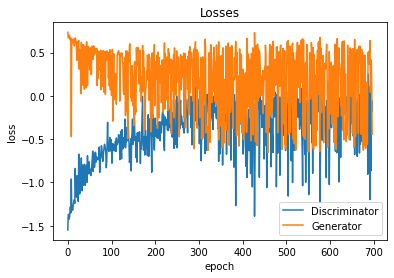

In [ ]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

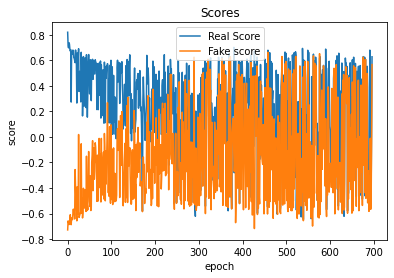

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

In [ ]:
import glob
from PIL import Image

# filepaths
fp_in = "/content/samples/fake_images-*.png"
fp_out = "/content/samples/fake_image.gif"

imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
img = next(imgs)  # extract first image from iterator
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=200, loop=0)

In [ ]:
from IPython.display import Image

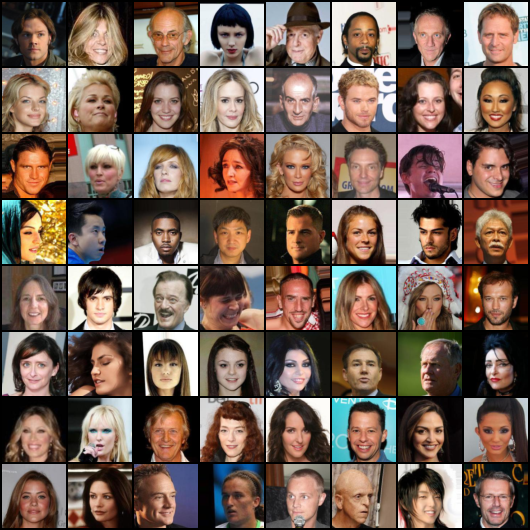

In [ ]:
Image("/content/samples/real_images.png")

In [ ]:
fake_fname = 'fake_images-{0:0=4d}.png'.format(num_epochs)
Image(os.path.join(sample_dir, fake_fname))